In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from matplotlib.animation import FuncAnimation

In [2]:
n_samples=1_000
data, _ = make_moons(n_samples=n_samples, noise=0.05)

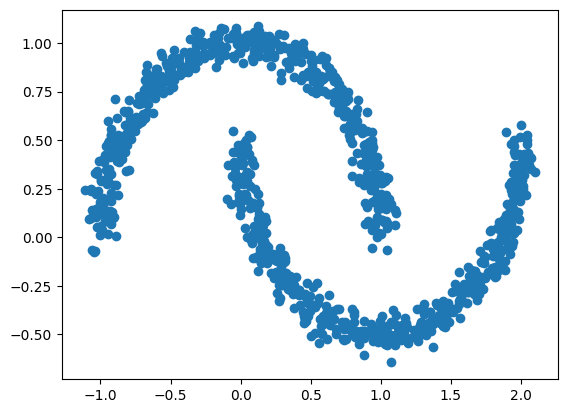

In [3]:
fig=plt.scatter(data[:,0], data[:,1])

In [4]:
class FlowMatching(keras.Model):
    def __init__(self, n_units, n_layers, dim=2):
        super(FlowMatching, self).__init__()
        self.dim = dim
        self.velocity = keras.Sequential(
            [keras.layers.Dense(n_units, activation="elu") for _ in range(n_layers)]
            )
        self.velocity.add(keras.layers.Dense(dim))

    def call(self, inputs):
        x_0, x_1, t = inputs.values()
        x_t = self.interpolate(x_0, x_1, t)
        x = keras.ops.concatenate([x_t, t], axis=-1)
        return self.velocity(x)

    def interpolate(self, x_0, x_1, t):
        return (1-t)*x_1 + t*x_0

    def step(self, x, t, dt):
        t = np.zeros_like(x) + t
        input = keras.ops.concatenate([x, t], axis=-1)
        velocity = self.velocity(input)
        return x + dt * velocity

    def run(self, x, steps):
        time = np.linspace(0, 1, steps)
        dt = 1 / steps
        output = []
        output.append(x)
        for t in time:
            x = self.step(x, t, dt)
            output.append(x)
        
        return output

    def sample(self, n_samples, steps):
        x_0 = np.random.normal(size=(n_samples, self.dim))
        x_1 = self.run(x_0, steps)
        return np.array(x_1).swapaxes(0, 1)
        
        

In [5]:
flow = FlowMatching(n_units=64, n_layers=8)

In [6]:
class DataSet(keras.utils.PyDataset):
    def __init__(self, batch_size, n_batches):
        super().__init__()
        self.n_batches=n_batches
        self.batch_size = batch_size
    
    @property
    def num_batches(self):
        return self.n_batches

    def __getitem__(self, index):
        data, _ = make_moons(n_samples=self.batch_size, noise=0.05)
        base = np.random.normal(size=data.shape)
        t = np.random.uniform(low=0, high=1, size=data.shape[0])
        t = np.repeat(t[:,np.newaxis], repeats=data.shape[1], axis=1)

        target = data - base
        return dict(x_0=base, x_1=data, t=t), target

In [7]:
def get_lr(optimizer):
    def lr(*args, **kwargs):
        return optimizer.learning_rate
    return lr

In [8]:
epochs=50
batches=1000
batch_size=1024

dataset=DataSet(batch_size=batch_size, n_batches=epochs*batches)

schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=epochs*batches)
optimizer = keras.optimizers.Adam(schedule, global_clipnorm=1.0)
lr_metric = get_lr(optimizer)

flow.compile(
    optimizer=optimizer,
    metrics=[lr_metric],
    loss=keras.losses.MeanSquaredError()
)

In [9]:
history=flow.fit(x=dataset, epochs=epochs, steps_per_epoch=batches)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0909 - lr: 0.0100
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9702 - lr: 0.0100
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9653 - lr: 0.0099
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9654 - lr: 0.0099
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9626 - lr: 0.0098
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9600 - lr: 0.0097
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9611 - lr: 0.0096
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9570 - lr: 0.0095
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9598 - lr: 0.0093
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9592 - lr: 0.0092
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9564 - lr: 0.0090
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9583 - lr: 0.0088
Epoch 13/50
1

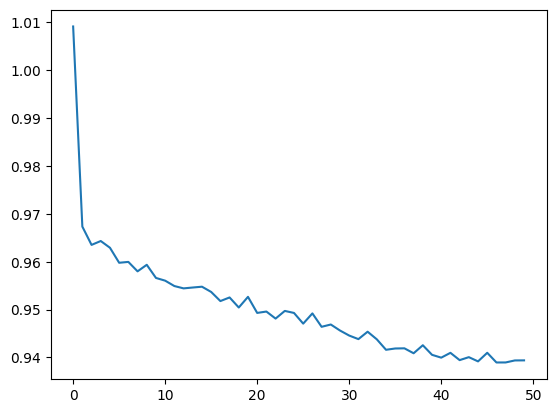

In [10]:
f=plt.plot(history.history["loss"])

In [11]:
x = flow.sample(n_samples=n_samples, steps=100)

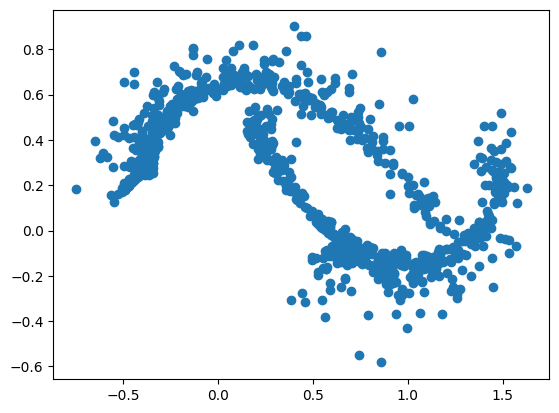

In [12]:
f=plt.scatter(x[:, -1, 0], x[:, -1, 1])

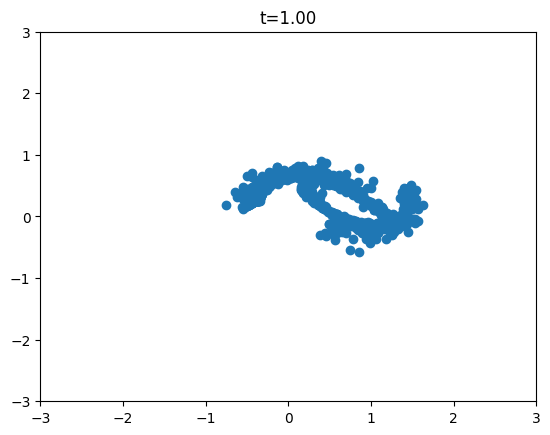

In [13]:
fig, ax = plt.subplots()

def animate(i):
    fig.clear()
    ax = fig.add_subplot()
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    t = np.linspace(0, 1, x.shape[1])[i]
    ax.set_title("t={0:.2f}".format(t))
    s = ax.scatter(x[:,i,0], x[:,i,1])

animation = FuncAnimation(fig, animate, interval=50, frames=range(x.shape[1]))
animation.save("flow-matching-moons.mp4", writer="ffmpeg")
plt.show()